In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import plotly.express as px

In [2]:
# Load pre-cleaned datasets from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set your folder path
folder = "/content/drive/MyDrive/Projects/tourism_revenue_political_stability_analysis"

# Load datasets
files_info = {
    'gdp_ppp.csv': 'gdp_ppp',
    'household_consumption.csv': 'household_consumption',
    'tourism_receipts.csv': 'tourism_receipts',
    'inflation.csv': 'inflation',
    'exchange_rate.csv': 'exchange_rate',
    'unemployment.csv': 'unemployment',
    'fdi.csv': 'fdi',
    'political_stability.csv': 'political_stability',
    'tourism_arrivals.csv': 'tourism_arrivals'
}

# Convert all to long format and merge
long_dfs = []
for filename, value_name in files_info.items():
    df = pd.read_csv(f"{folder}/{filename}", skiprows=4, engine='python', on_bad_lines='skip')
    df_long = df.melt(id_vars='Country Name', var_name='year', value_name=value_name)
    df_long.rename(columns={'Country Name': 'countryname'}, inplace=True)
    df_long = df_long[df_long['year'].str.isnumeric()].copy()
    df_long['year'] = df_long['year'].astype(int) + 1955
    long_dfs.append(df_long)

# Merge all long-format DataFrames
from functools import reduce
df = reduce(lambda left, right: pd.merge(left, right, on=['countryname', 'year'], how='inner'), long_dfs)

Mounted at /content/drive


In [3]:
# Rescale variables
df['gdp_ppp'] /= 1e12
df['household_consumption'] /= 1e12
df['tourism_receipts'] /= 1e9
df['tourism_arrivals'] /= 1e6

# Create interaction term
df['interaction'] = df['political_stability'] * df['household_consumption']

# Drop rows with missing critical variables
df = df.dropna(subset=[
    'tourism_receipts', 'household_consumption', 'political_stability',
    'gdp_ppp', 'inflation', 'exchange_rate', 'unemployment', 'fdi'
])

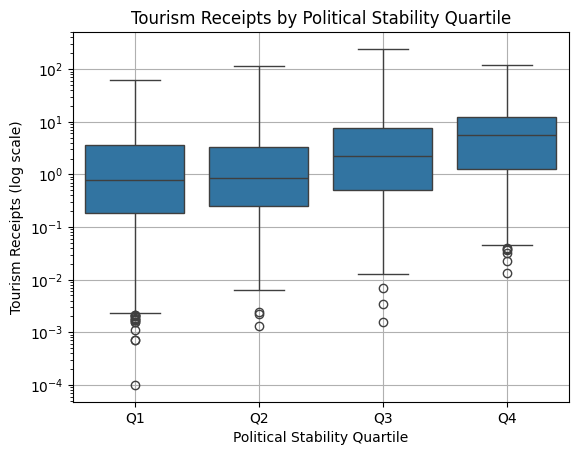

In [4]:
# Scale the Y-axis to log scale
plt.yscale('log')

# Create political stability quartiles (Q1 = lowest stability)
df['stability_quartile'] = pd.qcut(df['political_stability'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Boxplot of tourism receipts by political stability quartile
sns.boxplot(data=df, x='stability_quartile', y='tourism_receipts')
plt.yscale('log')
plt.title("Tourism Receipts by Political Stability Quartile")
plt.xlabel("Political Stability Quartile")
plt.ylabel("Tourism Receipts (log scale)")
plt.grid(True)
plt.show()

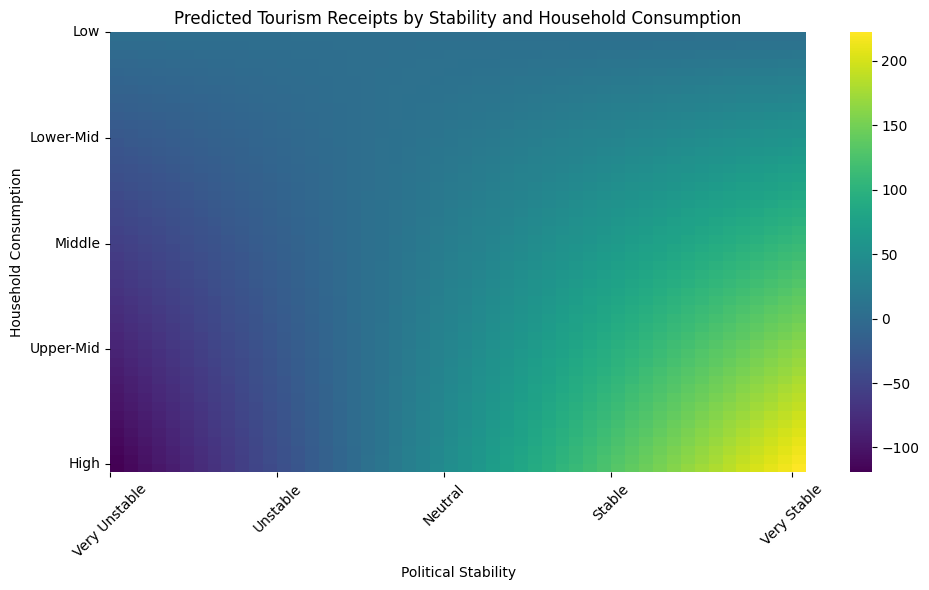

In [8]:
# Create grid of values for political stability and household consumption
stability_vals = np.linspace(df['political_stability'].min(), df['political_stability'].max(), 50)
consumption_vals = np.linspace(df['household_consumption'].min(), df['household_consumption'].max(), 50)

# Generate a DataFrame for predictions
from itertools import product
predict_df = pd.DataFrame(list(product(stability_vals, consumption_vals)), columns=['political_stability', 'household_consumption'])

# Add mean values for control variables to isolate interaction effect
predict_df['gdp_ppp'] = df['gdp_ppp'].mean()
predict_df['inflation'] = df['inflation'].mean()
predict_df['exchange_rate'] = df['exchange_rate'].mean()
predict_df['unemployment'] = df['unemployment'].mean()
predict_df['fdi'] = df['fdi'].mean()

# Predict receipts using model2
predict_df['predicted_receipts'] = model2.predict(predict_df)

# Pivot for heatmap-style plot
pivot = predict_df.pivot_table(
    values='predicted_receipts',
    index='household_consumption',
    columns='political_stability'
)

# Plot interaction as heatmap with clearer tick labels
plt.figure(figsize=(10, 6))
ax = sns.heatmap(pivot, cmap='viridis')

# Set axis labels and title
plt.title("Predicted Tourism Receipts by Stability and Household Consumption")
plt.xlabel("Political Stability")
plt.ylabel("Household Consumption")

# Customize axis ticks with descriptive labels
xticks = np.linspace(0, len(pivot.columns) - 1, 5).astype(int)
xlabels = ["Very Unstable", "Unstable", "Neutral", "Stable", "Very Stable"]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=45)

yticks = np.linspace(0, len(pivot.index) - 1, 5).astype(int)
ylabels = ["Low", "Lower-Mid", "Middle", "Upper-Mid", "High"]
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels, rotation=0)

plt.tight_layout()

plt.show()

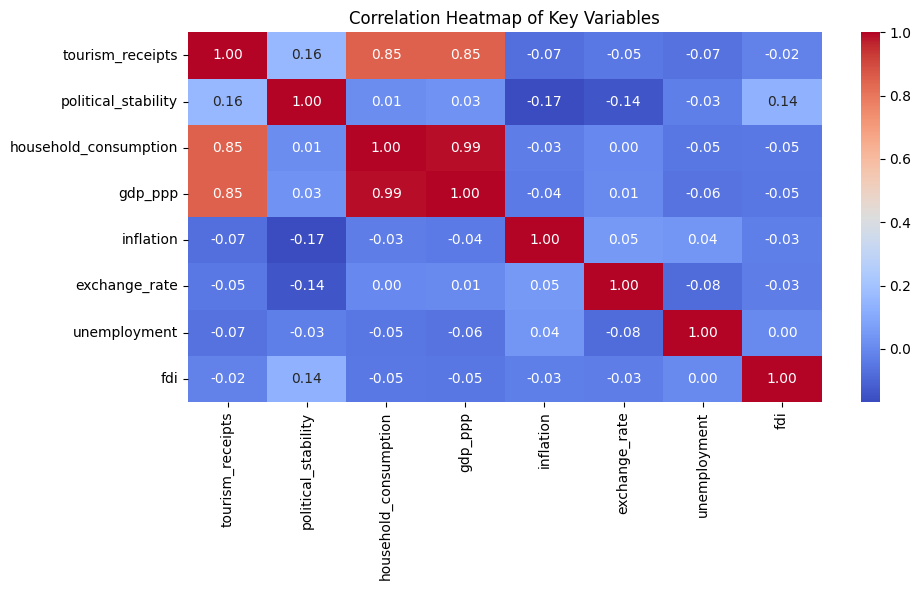

In [9]:
# Compute correlation matrix
corr = df[[
    'tourism_receipts', 'political_stability', 'household_consumption',
    'gdp_ppp', 'inflation', 'exchange_rate', 'unemployment', 'fdi'
]].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Key Variables")
plt.tight_layout()
plt.show()

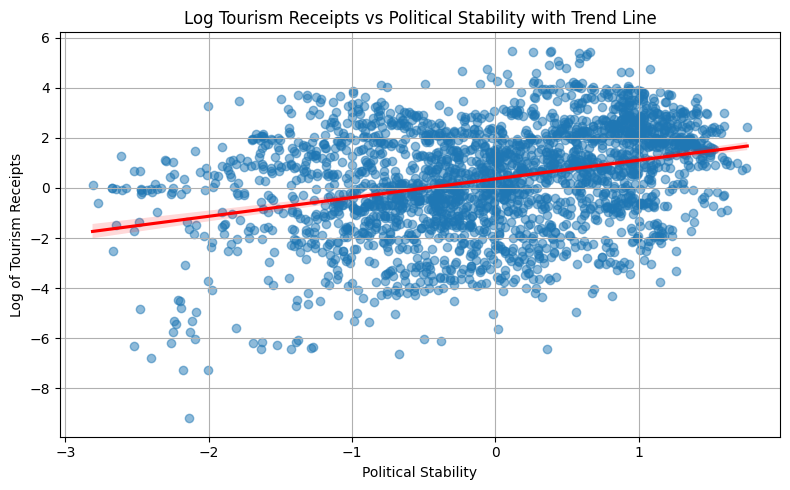

In [13]:
# Scatter Plot for Political Stability vs Tourism Receipts

# Create a copy to avoid modifying original DataFrame
df_plot = df.copy()

# Drop missing and log-transform receipts for regression
df_plot = df_plot.dropna(subset=['tourism_receipts', 'political_stability'])
df_plot['log_receipts'] = np.log(df_plot['tourism_receipts'])

# Plot scatter with regression line (in log space)
plt.figure(figsize=(8, 5))
sns.regplot(data=df_plot, x='political_stability', y='log_receipts', scatter_kws={'alpha': 0.5}, line_kws={"color": "red"})
plt.title("Log Tourism Receipts vs Political Stability with Trend Line")
plt.xlabel("Political Stability")
plt.ylabel("Log of Tourism Receipts")
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-11-cb6a95747550>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trend_data = df.groupby(['year', 'stability_quartile'])['tourism_receipts'].mean().reset_index()


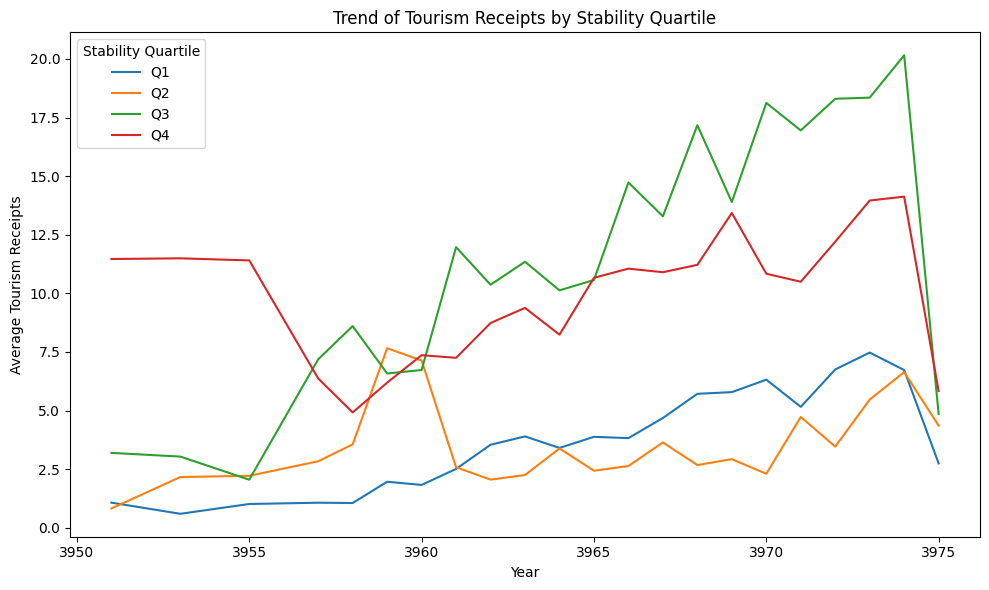

In [11]:
# Ensure quartile variable exists
if 'stability_quartile' not in df.columns:
    df['stability_quartile'] = pd.qcut(df['political_stability'], q=4, labels=["Q1", "Q2", "Q3", "Q4"])

# Group by year and stability quartile
trend_data = df.groupby(['year', 'stability_quartile'])['tourism_receipts'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=trend_data, x='year', y='tourism_receipts', hue='stability_quartile')
plt.title("Trend of Tourism Receipts by Stability Quartile")
plt.xlabel("Year")
plt.ylabel("Average Tourism Receipts")
plt.legend(title="Stability Quartile")
plt.tight_layout()
plt.show()

In [5]:
# Check and fix data types
df['tourism_receipts'] = pd.to_numeric(df['tourism_receipts'], errors='coerce')
df['tourism_arrivals'] = pd.to_numeric(df['tourism_arrivals'], errors='coerce')

numeric_vars = [
    'political_stability', 'household_consumption', 'gdp_ppp',
    'inflation', 'exchange_rate', 'unemployment', 'fdi'
]
for var in numeric_vars:
    df[var] = pd.to_numeric(df[var], errors='coerce')

# Regression: Base model
model1 = smf.ols(
    "tourism_receipts ~ political_stability + household_consumption + gdp_ppp + inflation + exchange_rate + unemployment + fdi",
    data=df
).fit()
print(model1.summary())

# Regression: With interaction term
model2 = smf.ols(
    "tourism_receipts ~ political_stability * household_consumption + gdp_ppp + inflation + exchange_rate + unemployment + fdi",
    data=df
).fit()
print(model2.summary())

# Regression: Using arrivals instead of receipts
# Ensure arrivals is also non-missing for this regression
df_arrivals = df.dropna(subset=["tourism_arrivals"])
model3 = smf.ols(
    "tourism_arrivals ~ political_stability * household_consumption + gdp_ppp + inflation + exchange_rate + unemployment + fdi",
    data=df_arrivals
).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:       tourism_receipts   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     1041.
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        15:24:13   Log-Likelihood:                -8944.2
No. Observations:                2454   AIC:                         1.790e+04
Df Residuals:                    2446   BIC:                         1.795e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.94